# CNN 2D Implementation

Assurez-vous que vous avez déjà exécuté le notebook de :
- [la préparation du dataset](prepDataset.ipynb)
- [classification CNN (1D)](cnn-classification.ipynb)

Ces fichiers sont très similaires au précédent, mais avec des changements majeurs, c'est-à-dire, (comme indiqué dans la version finale de notre article), nous avons effectué une transformation de 1D à 2D. En ajoutant le nombre de paramètres, nous avons constaté que le taux de précision s'est amélioré.

In [56]:
import numpy as np
from joblib import load, dump
import time
import matplotlib.pyplot as plt
import tqdm
from tqdm import trange

## Générer l'itérateur des ensembles de données

La difference : cette fois-ci, nous utilisons la taille 1024 pour les ensembles de données.

In [64]:
np.random.seed(100)  

def dataloader(batch_size, workers=2):
    def create_batches(xdata, ylabel, batch_size):
        # Shuffling data
        indices = np.arange(xdata.shape[0])
        np.random.shuffle(indices)
        xdata = xdata[indices]
        ylabel = ylabel[indices]
        
        # Creating batches
        num_batches = xdata.shape[0] // batch_size
        batches = []
        for i in range(num_batches):
            x_batch = xdata[i * batch_size:(i + 1) * batch_size]
            y_batch = ylabel[i * batch_size:(i + 1) * batch_size]
            batches.append((x_batch, y_batch))
        
        return batches

    train_xdata = load('files/trainX_1024_10c')
    train_ylabel = load('files/trainY_1024_10c')
    
    val_xdata = load('files/valX_1024_10c')
    val_ylabel = load('files/valY_1024_10c')

    test_xdata = load('files/testX_1024_10c')
    test_ylabel = load('files/testY_1024_10c')

    train_loader = create_batches(train_xdata, train_ylabel, batch_size)
    val_loader = create_batches(val_xdata, val_ylabel, batch_size)
    test_loader = create_batches(test_xdata, test_ylabel, batch_size)
    
    return train_loader, val_loader, test_loader

batch_size = 32

train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break


43
14
14
torch.Size([32, 1024]) torch.Size([32])


## Définir le modèle

In [65]:
class Conv2D:
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.1
        self.bias = np.zeros(output_channels)

    def forward(self, x):
        batch_size, _, height, width = x.shape
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, self.output_channels, out_height, out_width))

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        start_i = i * self.stride
                        start_j = j * self.stride
                        end_i = start_i + self.kernel_size
                        end_j = start_j + self.kernel_size
                        out[b, o, i, j] = np.sum(padded_x[b, :, start_i:end_i, start_j:end_j] * self.weights[o]) + self.bias[o]

        self.cache = (x, out)
        return out

    def backward(self, dout, learning_rate=0.01):
        x, out = self.cache
        batch_size, _, height, width = x.shape
        _, _, out_height, out_width = dout.shape

        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        dweights = np.zeros_like(self.weights)
        dbias = np.zeros_like(self.bias)
        dx = np.zeros_like(padded_x)

        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        start_i = i * self.stride
                        start_j = j * self.stride
                        end_i = start_i + self.kernel_size
                        end_j = start_j + self.kernel_size
                        dweights[o] += dout[b, o, i, j] * padded_x[b, :, start_i:end_i, start_j:end_j]
                        dbias[o] += dout[b, o, i, j]
                        dx[b, :, start_i:end_i, start_j:end_j] += dout[b, o, i, j] * self.weights[o]

        dx = dx[:, :, self.padding:-self.padding, self.padding:-self.padding]

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx

In [67]:
class ReLU:
    def forward(self, x):
        self.cache = x
        return np.maximum(0, x)

    def backward(self, dout, lr):
        x = self.cache
        dx = dout * (x > 0)
        return dx

In [66]:
class MaxPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1
        out = np.zeros((batch_size, channels, out_height, out_width))

        self.cache = (x, out_height, out_width)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        start_i = i * self.stride
                        start_j = j * self.stride
                        end_i = start_i + self.kernel_size
                        end_j = start_j + self.kernel_size
                        out[b, c, i, j] = np.max(x[b, c, start_i:end_i, start_j:end_j])

        return out

    def backward(self, dout, lr):
        x, out_height, out_width = self.cache
        batch_size, channels, height, width = x.shape
        dx = np.zeros_like(x)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        start_i = i * self.stride
                        start_j = j * self.stride
                        end_i = start_i + self.kernel_size
                        end_j = start_j + self.kernel_size
                        max_val = np.max(x[b, c, start_i:end_i, start_j:end_j])
                        dx[b, c, start_i:end_i, start_j:end_j] += (x[b, c, start_i:end_i, start_j:end_j] == max_val) * dout[b, c, i, j]

        return dx


In [68]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.1
        self.bias = np.zeros(output_dim)

    def forward(self, x):
        self.cache = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, dout, learning_rate=0.01):
        x = self.cache
        dweights = np.dot(x.T, dout)
        dbias = np.sum(dout, axis=0)
        dx = np.dot(dout, self.weights.T)

        self.weights -= learning_rate * dweights
        self.bias -= learning_rate * dbias

        return dx


In [ ]:
class AdaptiveAvgPool2D:
    def __init__(self, output_size):
        self.output_size = output_size

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        stride_h = height // self.output_size[0]
        stride_w = width // self.output_size[1]
        out = np.zeros((batch_size, channels, self.output_size[0], self.output_size[1]))

        for b in range(batch_size):
            for c in range(channels):
                for i in range(self.output_size[0]):
                    for j in range(self.output_size[1]):
                        start_i = i * stride_h
                        start_j = j * stride_w
                        end_i = start_i + stride_h
                        end_j = start_j + stride_w
                        out[b, c, i, j] = np.mean(x[b, c, start_i:end_i, start_j:end_j])
                        
        self.cache = (x, stride_h, stride_w)
        return out

    def backward(self, dout):
        x, stride_h, stride_w = self.cache
        batch_size, channels, height, width = x.shape
        dx = np.zeros_like(x)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(self.output_size[0]):
                    for j in range(self.output_size[1]):
                        start_i = i * stride_h
                        start_j = j * stride_w
                        end_i = start_i + stride_h
                        end_j = start_j + stride_w
                        dx[b, c, start_i:end_i, start_j:end_j] += dout[b, c, i, j] / (stride_h * stride_w)
        
        return dx

La CNN 2D Modèle finale est défini au-dessous :

In [59]:
class CNN2DModel:
    def __init__(self, conv_archs, num_classes, batch_size, input_channels=1):
        self.batch_size = batch_size
        self.conv_arch = conv_archs 
        self.input_channels = input_channels 
        self.features = self.make_layers()
        self.avgpool = AdaptiveAvgPool2D((3, 3))
        self.classifier = [
            Linear(128 * 3 * 3, 500),
            ReLU(),
            Linear(500, num_classes),
        ]
        
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(Conv2D(self.input_channels, out_channels))
                layers.append(ReLU())
                self.input_channels = out_channels
            layers.append(MaxPool2D())
        return layers

    def forward(self, input_seq):
        input_seq = input_seq.reshape(self.batch_size, 1, 32, 32)
        input_seq = np.transpose(input_seq, (0, 1, 3, 2))
        
        for layer in self.features:
            input_seq = layer.forward(input_seq)
        
        x = self.avgpool.forward(input_seq)

        print(x.shape)
        
        flat_tensor = x.reshape(self.batch_size, -1)
        
        for layer in self.classifier:
            flat_tensor = layer.forward(flat_tensor)
        
        return flat_tensor

    def backward(self, dout, learning_rate=0.01):
        for layer in reversed(self.classifier):
            dout = layer.backward(dout, learning_rate)
        
        dout = dout.reshape(self.batch_size, 128, 3, 3)
        dout = self.avgpool.backward(dout)
        
        for layer in reversed(self.features):
            dout = layer.backward(dout, learning_rate)

Fonctions pour classfications des images de chiffres manuscrits de 0 à 9.

In [72]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(pred, target):
    exps = np.exp(pred - np.max(pred, axis=1, keepdims=True))
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    batch_size = target.shape[0]
    num_classes = pred.shape[1]
    one_hot_target = np.zeros_like(pred)
    one_hot_target[np.arange(batch_size), target] = 1
    log_probs = -np.log(probs[np.arange(batch_size), target])
    loss = np.sum(log_probs)
    grad = probs - one_hot_target
    return loss, grad

def model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function):
    train_size = len(train_loader) # * batch_size
    val_size = len(val_loader) # * batch_size

    best_accuracy = 0.0
    best_model = model

    train_loss = []  
    train_acc = []   
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        loss_epoch = 0.0    
        correct_epoch = 0 
        for seq, labels in train_loader: 

            # print(seq.size(), labels.size()) 
            seq = seq.reshape((32, 1, 1024))

            # Forward
            y_pred = model.forward(seq)

            probabilities = softmax(y_pred) # Softmax pour avoir des probabilités
            predicted_labels = np.argmax(probabilities, axis=1)

            correct_epoch += np.sum(predicted_labels == labels)

            loss, dout = loss_function(y_pred, labels)
            loss_epoch += loss
            print(f'Pour cette epoch, le loss est {loss_epoch}')
            model.backward(dout / batch_size)

        train_accuracy = correct_epoch / train_size 
        train_loss.append(loss_epoch / train_size)
        train_acc.append(train_accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_accuracy:4.4f}')
        
        loss_validate = 0.0
        correct_validate = 0
        for data, label in val_loader:
            pre = model.forward(data)
            val_loss, _ = loss_function(pre, label)
            loss_validate += val_loss
            correct_validate += np.sum(np.argmax(pre, axis=1) == label)
            # break

        val_accuracy = correct_validate / val_size 
        print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
        validate_loss.append(loss_validate / val_size)
        validate_acc.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

    dump(best_model, 'best_model_cnn2d.pkl')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color='b', label='train_loss')
    plt.plot(range(epochs), train_acc, color='g', label='train_acc')
    plt.plot(range(epochs), validate_loss, color='y', label='validate_loss')
    plt.plot(range(epochs), validate_acc, color='r', label='validate_acc')
    plt.legend()
    plt.show()
    print("best_accuracy :", best_accuracy)



## Entraîner le modèle
Dans cette section, nous allons entraîner le modèle. 

$$
\color{red}
\text{-----------------------Veuillez lire ceci en premier !!!-----------------------}
$$

Il est très chronophage d'entraîner un modèle CNN. Pour expliquer pourquoi c'est ainsi, le nombre de paramètres dans le modèle est de $683430$. Ci-dessous, vous pouvez essayer par vous-même d'exécuter la fonction `model_train` et observer comment elle fonctionne.

Nous avons enregistré les résultats de la sortie de cette fonction en la faisant fonctionner pendant plus de 60 heures. Les valeurs ont été enregistrées dans les fichiers respectivement nommés `tl2d.npy`, `vl2d.npy`, `ta2d.npy`, et `va2d.npy`. Vous pouvez charger ces fichiers et tracer les résultats. Ces valeurs sont respectivement la perte d'entraînement, la perte de validation, la précision d'entraînement et la précision de validation.


In [ ]:
batch_size = 32
epochs = 100

train_loader, val_loader, test_loader = dataloader(batch_size)

model = CNN2DModel(conv_archs=[(2, 32), (1, 64), (1, 128)], num_classes=10, batch_size=batch_size)

model_train(batch_size, epochs, train_loader, val_loader, model, None, cross_entropy_loss)

## Resultats

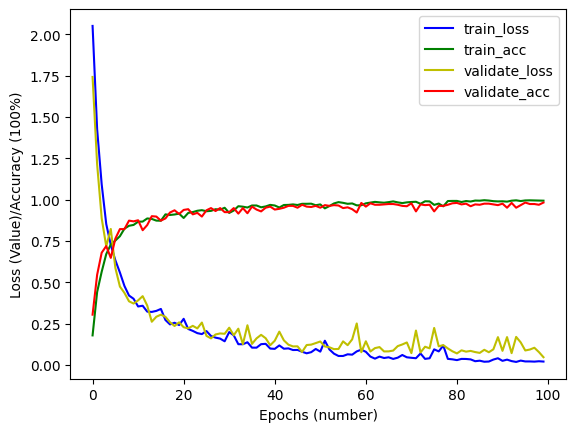

In [75]:
tl2d = np.load("files/tl2d.npy")
ta2d = np.load("files/ta2d.npy")
vl2d = np.load("files/vl2d.npy")
va2d = np.load("files/va2d.npy")


plt.xlabel('Epochs (number)')
plt.ylabel('Loss (Value)/Accuracy (100%)')
plt.plot(tl2d, color='b', label='train_loss')
plt.plot(ta2d, color='g', label='train_acc')
plt.plot(vl2d, color='y', label='validate_loss')
plt.plot(va2d, color='r', label='validate_acc')
plt.legend()

In [78]:
print('Accuracy pourcentage: (test / validation)')
print(ta2d[-1]), print(va2d[-1])

Accuracy pourcentage: (test / validation)
0.9934593023255814
0.9821428571428571


(None, None)